In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

We are taking dataset from the link, [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) which consists of 3670 records

In [2]:
(training_set,validation_set),dataset_info = tfds.load('tf_flowers',split=['train[:70%]','train[70%:]'],
                                                       with_info = True,as_supervised = True)

Shuffling and writing examples to /root/tensorflow_datasets/tf_flowers/3.0.0.incompleteQ1SSUL/tf_flowers-train.tfrecord


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


**Lets Check the number of classes in the dataset**

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [4]:
training_set

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [5]:
num_classes = dataset_info.features['label'].num_classes

num = dataset_info.features['label'].names

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print(f'There"re {num_classes} classes in the dataset')
print('The labels are {}'.format(num))
print(f'There"re {num_training_examples} training examples and {num_validation_examples} validation examples')

There"re 5 classes in the dataset
The labels are ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
There"re 2569 training examples and 1101 validation examples


**Reformating the image to apply MobileNet V2 (224 X 224)**

In [0]:
image_resolution = 224

def image_format(image,label):
  image = tf.image.resize(image,(image_resolution,image_resolution))/255.0
  return image,label

batch_size = 32

train_batches = training_set.shuffle(num_training_examples//4).map(image_format).batch(batch_size).prefetch(1)

validation_branches = validation_set.map(image_format).batch(batch_size).prefetch(1)

**Create Feature Extractor using [Pre-trained model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2)**

In [0]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(url,input_shape = (image_resolution,image_resolution,3))

#Freezing the pre-trained model

feature_extractor.trainable = False

**Attach the last layer with the pre-trained layers**

In [8]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes) ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


**Fiiting the Model**

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics = ['accuracy'])

epochs = 6

history = model.fit(train_batches,epochs=epochs,validation_data=validation_branches)

Epoch 1/6
81/81 [==============================] - 7s 93ms/step - loss: 0.7696 - accuracy: 0.7158 - val_loss: 0.4715 - val_accuracy: 0.8374
Epoch 2/6
81/81 [==============================] - 7s 82ms/step - loss: 0.3877 - accuracy: 0.8665 - val_loss: 0.3714 - val_accuracy: 0.8774
Epoch 3/6
81/81 [==============================] - 7s 83ms/step - loss: 0.3090 - accuracy: 0.8949 - val_loss: 0.3248 - val_accuracy: 0.8910
Epoch 4/6
81/81 [==============================] - 7s 83ms/step - loss: 0.2496 - accuracy: 0.9268 - val_loss: 0.3142 - val_accuracy: 0.8992
Epoch 5/6
81/81 [==============================] - 7s 83ms/step - loss: 0.2164 - accuracy: 0.9358 - val_loss: 0.3037 - val_accuracy: 0.9010
Epoch 6/6
81/81 [==============================] - 7s 84ms/step - loss: 0.1948 - accuracy: 0.9447 - val_loss: 0.2929 - val_accuracy: 0.8937


**Plotting Curves**

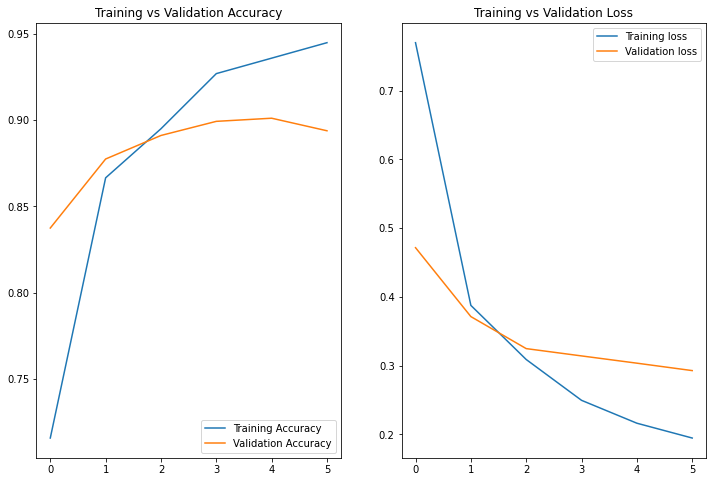

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range,val_loss,label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training vs Validation Loss')
plt.show()

**Create batch and Make Predictions**

In [11]:
print(f'The labels are {num}')

The labels are ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [20]:
num = np.array(num)
num

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [16]:
next(iter(train_batches)) #acts like a generator

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[1.69169083e-01, 1.63026303e-01, 1.45529151e-01],
          [1.41863629e-01, 1.39628753e-01, 1.27414867e-01],
          [1.73787668e-01, 1.63948715e-01, 1.56563491e-01],
          ...,
          [1.25996336e-01, 8.94097164e-02, 6.76416904e-02],
          [1.40482008e-01, 1.62020966e-01, 1.14284799e-01],
          [3.03748667e-01, 3.09214175e-01, 1.88514218e-01]],
 
         [[2.45493591e-01, 2.05440298e-01, 2.04638273e-01],
          [1.32171839e-01, 1.40812099e-01, 1.38887435e-01],
          [1.83469549e-01, 1.57739744e-01, 1.43597350e-01],
          ...,
          [8.54678899e-02, 8.10784847e-02, 3.41098793e-02],
          [2.41702363e-01, 2.73442119e-01, 1.49257019e-01],
          [4.18171704e-01, 4.79434192e-01, 3.95010293e-01]],
 
         [[2.70541161e-01, 2.37102270e-01, 2.22855940e-01],
          [1.88848600e-01, 1.94990814e-01, 1.89310879e-01],
          [2.09293485e-01, 1.93595722e-01, 1.67724743e-01],
    

In [21]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=1)
predicted_class_names = num[predicted_ids]

print(predicted_class_names)

['sunflowers' 'sunflowers' 'sunflowers' 'dandelion' 'dandelion'
 'dandelion' 'tulips' 'dandelion' 'daisy' 'dandelion' 'daisy' 'tulips'
 'roses' 'dandelion' 'dandelion' 'dandelion' 'roses' 'dandelion' 'daisy'
 'dandelion' 'tulips' 'daisy' 'dandelion' 'daisy' 'dandelion' 'dandelion'
 'daisy' 'tulips' 'tulips' 'sunflowers' 'tulips' 'dandelion']


**Compare True labels and Predicted labels**

In [22]:
print('Labels: ',label_batch)
print('Predicted: ',predicted_ids)

Labels:  [3 3 3 0 0 0 2 0 1 0 1 2 4 0 0 0 4 0 1 0 2 1 0 1 0 0 1 2 2 3 2 0]
Predicted:  [3 3 3 0 0 0 2 0 1 0 1 2 4 0 0 0 4 0 1 0 2 1 0 1 0 0 1 2 2 3 2 0]


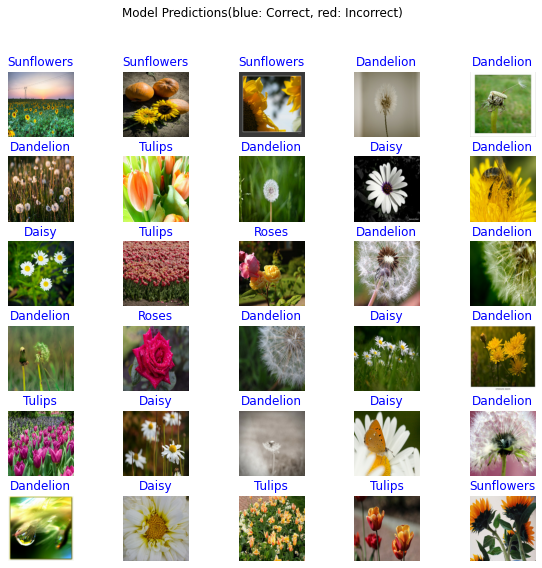

In [23]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(),color = color)
  plt.axis('off')
  _ = plt.suptitle('Model Predictions(blue: Correct, red: Incorrect)')

**Lets try with Inception V3 Architecture (299 X 299)**

In [26]:
image_resolution = 299
BATCH_SIZE = 32

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

def image_format(image,label):
  image = tf.image.resize(image,(image_resolution,image_resolution))/255.0
  return image,label


train_batches = training_set.shuffle(num_training_examples//4).map(image_format).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(image_format).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(image_resolution, image_resolution, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 17s 212ms/step - loss: 0.7126 - accuracy: 0.7509 - val_loss: 0.4409 - val_accuracy: 0.8683
Epoch 2/6
81/81 [==============================] - 14s 174ms/step - loss: 0.3817 - accuracy: 0.8793 - val_loss: 0.3679 - val_accuracy: 0.8783
Epoch 3/6
81/81 [==============================] - 14s 177ms/step - loss: 0.2990 - accuracy: 0.9089 - val_loss: 0.3114 - val_accuracy: 0.9019
Epoch 4/6
81/81 [==============================] - 14s 178ms/step - loss: 0.2626 - accuracy: 0.9249 - val_loss: 0.2905 - val_accuracy: 0.9019
Epoch 5/6
81/81 [==============================] - 14s 176ms/step - loss: 0.2227 - accuracy: 0.9346 - val_loss: 0.2811 - val_accuracy: 0.9037
Epoch 6/6
81/81 [==============================] - 14s 175ms/step - loss: 0.2035 - accuracy: 0.9432 - val_loss: 0.2877 - val_accuracy: 0.8983


**Train with Resnet Feature Extractor**

In [30]:
image_resolution = 224
BATCH_SIZE = 32

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

def image_format(image,label):
  image = tf.image.resize(image,(image_resolution,image_resolution))/255.0
  return image,label


train_batches = training_set.shuffle(num_training_examples//4).map(image_format).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(image_format).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/imagenet/resnet_v1_101/classification/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(image_resolution, image_resolution, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              44656553  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5010      
Total params: 44,661,563
Trainable params: 5,010
Non-trainable params: 44,656,553
_________________________________________________________________


In [31]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 16s 202ms/step - loss: 0.8300 - accuracy: 0.7345 - val_loss: 0.4670 - val_accuracy: 0.8392
Epoch 2/6
81/81 [==============================] - 15s 189ms/step - loss: 0.3913 - accuracy: 0.8641 - val_loss: 0.3827 - val_accuracy: 0.8638
Epoch 3/6
81/81 [==============================] - 15s 189ms/step - loss: 0.3093 - accuracy: 0.8902 - val_loss: 0.3612 - val_accuracy: 0.8719
Epoch 4/6
81/81 [==============================] - 15s 190ms/step - loss: 0.2543 - accuracy: 0.9101 - val_loss: 0.3558 - val_accuracy: 0.8719
Epoch 5/6
81/81 [==============================] - 16s 193ms/step - loss: 0.2114 - accuracy: 0.9268 - val_loss: 0.3196 - val_accuracy: 0.8928
Epoch 6/6
81/81 [==============================] - 16s 192ms/step - loss: 0.1850 - accuracy: 0.9432 - val_loss: 0.3197 - val_accuracy: 0.8874
